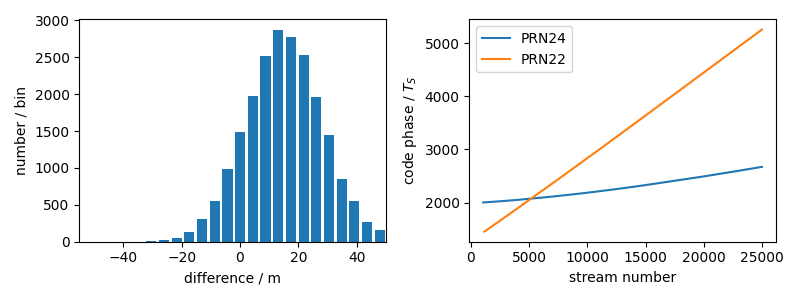

In [52]:
# Example 14: pseudo-range (3) (measured every 32 ms)

%matplotlib widget 

import json
import gpslib_18 as gpslib
import numpy as np
import matplotlib.pyplot as plt

# possible satellites 10,12,13,15,17,22,23,24,25
SAT0 = 24
SAT1 = 22 # 25
#CORR = False
#CORR = True

REL_CORR = False
EARTH_ROT_CORR = True

GPS_C  = 2.99792458e8
SMP_RATE = 2.048E6    
NCYC = 32
SAMPLE_RATE = 2.048E6
CODE_SAMPLES = 2048
NGPS = CODE_SAMPLES*NCYC
REC_POS = (4141657.6,604772.9,4796731.9)   
TOW_0 = 69447                # behind last code phase error
snoStart = 1000    


def rotEarth(pos,pt):                            # pos = (x,y,z); pt is propagation time
    omegaEarth = 7.292115147e-5                  # rad/sec
    dp = np.array([-pos[1],pos[0],0])*omegaEarth * pt
    return dp

def getStdDev(tcpLst,cophLst):
    p = np.polyfit(tcpLst,cophLst,14)
    fit = np.poly1d(p)
    cophStd = np.std(cophLst-fit(tcpLst))  
    cophStd *= GPS_C/SAMPLE_RATE             # standard deviation in m
    return cophStd

def cpOflCorrection(cplst):
    cpl = cplst.copy()
    ovfl = 0    
    pno,pcp = cpl[0]
    for i in range(1,len(cpl)):        
        no,cp = cpl[i]
        cp += ovfl*CODE_SAMPLES
        d = pcp - cp
        if np.isclose(abs(d),CODE_SAMPLES,rtol=1E-5,atol=200):
            cp += np.sign(d)*CODE_SAMPLES                     
            ovfl += np.sign(d) 
        cpl[i] = (no,cp)
        pno,pcp = no,cp                                       
    return cpl


def loadCpLst(satNo):
    global DATA
    with open('../t/gpsCP_140923-t04.json','r') as file:
        DATA=json.load(file)     
    return DATA[str(satNo)]


with open('../t/gpsFrames_140923_results.json','r') as file:
    FRAME_LST=json.load(file)  
            
cpLst,satData,satPos,sfLst,ST,ST_SNO,res = {},{},{},{},{},{},{}

for satNo in [SAT0,SAT1]:
    cpLst[satNo] = loadCpLst(satNo)
    cpLst[satNo] = cpOflCorrection(cpLst[satNo][snoStart:])    
    satData[satNo] = gpslib.SatData(satNo)
    satPos[satNo] = gpslib.SatPos()    
    sfLst[satNo] = list(filter(lambda item:item['SAT']==satNo,FRAME_LST))
    res[satNo] = []   
    timeRefOk = False
    for sf in sfLst[satNo]:
        satData[satNo].readSubframe(sf)        
        if sf['tow'] == TOW_0:            
            ST[satNo] = (sf['ST'] // CODE_SAMPLES) * CODE_SAMPLES   # get rid of delay
            ST_SNO[satNo] = ST[satNo] // NGPS
            timeRefOk = True
        if timeRefOk and satData[satNo].ephemOk:
            break            
    for sno,cp in cpLst[satNo]:
        n = sno - ST_SNO[satNo]
        if n >= 0:
            dt = n*NGPS/SMP_RATE        
            x,y,z,d_st = satPos[satNo].ecefCoord(TOW_0,satData[satNo].ephemData,DT=dt,relCorr=REL_CORR)
            dist = np.sqrt((x-REC_POS[0])**2+(y-REC_POS[1])**2+(z-REC_POS[2])**2)

            if EARTH_ROT_CORR:
                propTime = dist/GPS_C
                deltaPos = rotEarth(REC_POS,propTime)
                dist = np.sqrt((x-REC_POS[0]-deltaPos[0])**2+(y-REC_POS[1]-deltaPos[1])**2+(z-REC_POS[2]-deltaPos[2])**2)
            
            smpTime = (ST[satNo] + cp)/SMP_RATE + dt + d_st
            res[satNo].append((n,dist,smpTime))
            
i0,i1,result = 0,0,[]
while i0 < len(res[SAT0]) and i1 < len(res[SAT1]):
    n0,d0,st0 = res[SAT0][i0]
    n1,d1,st1 = res[SAT1][i1]
    if n0 > n1:
        i1 += 1
    elif n0 < n1:
        i0 += 1
    else:                                                       
        diff = np.abs(d0-d1) - GPS_C*np.abs(st0-st1)
        result.append(diff)
        i0 += 1
        i1 += 1

mean = np.mean(result)
std  = np.std(result)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,3))
fig.canvas.header_visible = False
ax1.hist(result,bins=28,rwidth=0.8)
ax1.set_ylabel('number / bin')
ax1.set_xlabel('difference / m')
ax1.set_xlim(-55,50)

sn0,cp0 = zip(*cpLst[SAT0])
cp0Std = getStdDev(sn0,cp0)    
ax2.plot(sn0,cp0,label='PRN%02d' % (SAT0))
sn1,cp1 = zip(*cpLst[SAT1])
cp1Std = getStdDev(sn1,cp1)    
ax2.plot(sn1,cp1,label='PRN%02d' % (SAT1))
ax2.set_ylabel('code phase / $T_S$')
ax2.set_xlabel('stream number')
ax2.legend()

plt.tight_layout()
plt.show()

In [53]:
mean,std

(15.160198232108886, 13.265599334902532)

In [36]:
mean,std,cp0Std,cp1Std

(9.925892530318126, 14.685109332428793, 11.435067806086403, 9.538923334597117)